# Machine Learning Project 1: Overfitting, Underfitting and Metaparameters

## 1 Training and testing datasets

Commençons par importer les librairies nécessaires ainsi que les données, puis séparons-les en deux ensembles : un ensemble d'entraînement (train) et un ensemble de test.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

À propos du dataset :

La target (colonne à prédire) : Column 11 is a quantitative measure of disease progression one year after baseline

Attribute Information:
- age in years
- sex
- bmi body mass index
- bp average blood pressure
- s1 tc, total serum cholesterol
- s2 ldl, low-density lipoproteins
- s3 hdl, high-density lipoproteins
- s4 tch, total cholesterol / HDL
- s5 ltg, possibly log of serum triglycerides level
- s6 glu, blood sugar level

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation 

In [5]:
X, y= load_diabetes(return_X_y = True, as_frame = True)
diabetes_df = pd.concat([X, y], axis = 1)
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


Comme nous pouvons le voir, les données sont bien normalisées.

Chargeons les données sous forme de matrices pour pouvoir les manipuler par la suite et séparons-les (pour les séparer nous utilisons le random_state = 19).

In [7]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=19)

## 2 Writing our own model
Calculons la matrice des poids optimaux qui minimisent la MSE. 
Commençons par ajouter une constante de 1 afin d'inclure le biais dans le modèle.

Pour être sûr de notre modification affichons la première ligne de la matrice X_train avant et après la modification

In [10]:
X_train[0]

array([ 0.01264814,  0.05068012, -0.07195249, -0.04698463, -0.05110326,
       -0.09713731,  0.11859122, -0.0763945 , -0.02029232, -0.03835666])

In [11]:
X_train_1 = np.c_[np.ones(X_train.shape[0]), X_train]
#pas nécessaire de le faire sur l'ensemble X de test car il ne nous servira pas à déterminer les coefficients
X_test_1 = np.c_[np.ones(X_test.shape[0]), X_test]

In [12]:
X_train_1[0]

array([ 1.        ,  0.01264814,  0.05068012, -0.07195249, -0.04698463,
       -0.05110326, -0.09713731,  0.11859122, -0.0763945 , -0.02029232,
       -0.03835666])

Nous pouvons maintenant passer au calcul de la matrice des coefficients en utilisant la méthode de la pseudo-inverse.

In [14]:
feature_names = diabetes.feature_names
pseudo_inverse_X_train_1 = np.linalg.pinv(X_train_1)
coefficients = np.matmul(pseudo_inverse_X_train_1,y_train)

coefficients_df = pd.DataFrame(data = [coefficients], columns=['Intercept'] + list(feature_names), index = ["Valeurs"])

coefficients_df.T

,Valeurs
Intercept,151.667479
age,-46.289807
sex,-186.668002
bmi,517.427128
bp,280.236908
s1,-999.938343
s2,645.340859
s3,187.377693
s4,225.611912
s5,870.695971


Réalisons maintenant les prédictions sur l'ensemble de validation et calculons le score de performance R².

In [16]:
y_pred = np.matmul(X_test_1, coefficients)

r2 = r2_score(y_test, y_pred)
print("Le score de performance R² sur l'ensemble de test est de ", r2)

Le score de performance R² sur l'ensemble de test est de  0.47717743357156917


## 3 Lasso models from scikit-learn

Définissons le modèle avec un alpha de 0,5 et entraînons le modèle sur notre ensemble d'entraînement.

In [19]:
lasso = Lasso(alpha=0.5)
lasso.fit(X_train, y_train)

Lasso(alpha=0.5)

Réalisons les prédictions et calculons R².

In [21]:
y_pred_lasso= lasso.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Le score de performance R² sur l'ensemble de test est de ", r2_lasso)

Le score de performance R² sur l'ensemble de test est de  0.4077698997493745


Nous pouvons aussi extraire les coeficients pour les comparer à notre premier modèle

In [23]:
coefficients_lasso = lasso.coef_
intercept = lasso.intercept_

intercept_df = pd.DataFrame(data=[[intercept]], columns=["Intercept"], index=["Valeurs"])
coefficients_lasso_df = pd.DataFrame(data = [coefficients_lasso], columns=feature_names, index = ["Valeurs"])

coefficients_lasso_df = pd.concat([intercept_df, coefficients_lasso_df], axis=1)

coefficients_lasso_df.T

,Valeurs
Intercept,151.138640
age,0.000000
sex,-0.000000
bmi,456.134098
bp,81.631137
s1,-0.000000
s2,-0.000000
s3,-105.053401
s4,0.000000
s5,439.324290


## 4 Comparing models of increasing complexity

Commencons par créer les 100 valeurs d'alphas et entrainons les modèles.

In [25]:
values_alpha = np.linspace(0.1,1,100)

In [26]:
train_scores = []
test_scores = []

for alpha in values_alpha:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)

    train_r2 = lasso.score(X_train, y_train)
    test_r2 = lasso.score(X_test, y_test)
    
    train_scores.append(train_r2)
    test_scores.append(test_r2)

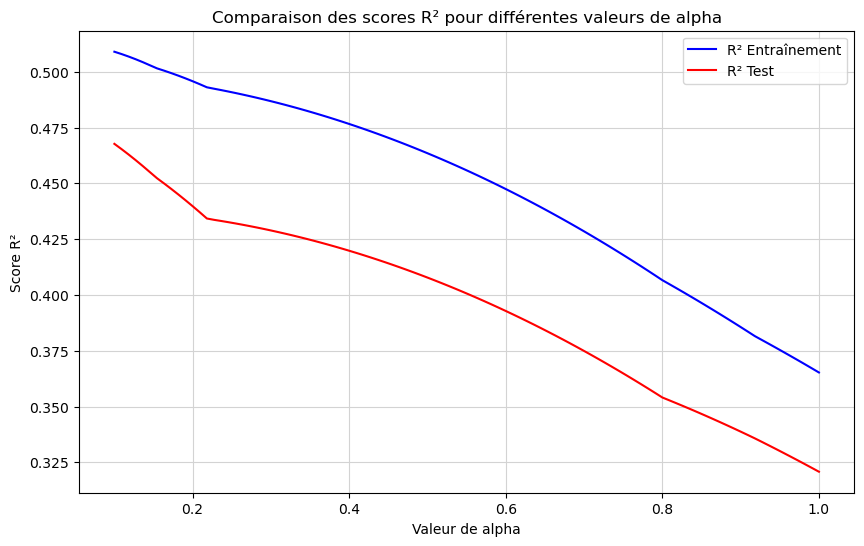

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(values_alpha, train_scores, label="R² Entraînement", color="blue")
plt.plot(values_alpha, test_scores, label="R² Test", color="red")
plt.xlabel("Valeur de alpha")
plt.ylabel("Score R²")
plt.title("Comparaison des scores R² pour différentes valeurs de alpha")
plt.legend()
plt.grid(color = "lightgray")
plt.show()

## Choose your model

In [29]:
param_grid = {'alpha': values_alpha}

lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='r2')  # cv=10 pour 10-fold cross-validation
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

final_model = Lasso(alpha=best_alpha)
final_model.fit(X_train, y_train)

final_train_r2 = final_model.score(X_train, y_train)
final_test_r2 = final_model.score(X_test, y_test)

print("L'Alpha optimal sélectionné par la Grid Search est :", best_alpha)
print("Le R² moyen de la validation croisée est de :", best_score)
print("Le R² sur l'ensemble d'entraînement est de :", final_train_r2)
print("Le R² sur l'ensemble de test est de :", final_test_r2)

L'Alpha optimal sélectionné par la Grid Search est : 0.1
Le R² moyen de la validation croisée est de : 0.45924552936239155
Le R² sur l'ensemble d'entraînement est de : 0.5089887532458452
Le R² sur l'ensemble de test est de : 0.46770551071206856


Affichons les coeficients

In [31]:
coefficients_lasso_final = final_model.coef_
intercept_final = final_model.intercept_

intercept_df = pd.DataFrame(data=[[intercept_final]], columns=["Intercept"], index=["Valeurs"])
coefficients_final_df = pd.DataFrame(data = [coefficients_lasso_final], columns=feature_names, index = ["Valeurs"])

coefficients_final_df = pd.concat([intercept_df, coefficients_final_df], axis=1)

coefficients_final_df.T

,Valeurs
Intercept,151.732051
age,-0.000000
sex,-96.151458
bmi,514.302320
bp,219.449096
s1,-45.562576
s2,-0.000000
s3,-228.639308
s4,0.000000
s5,528.203322
